In [38]:
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler


warnings.filterwarnings("ignore")
sns.set(rc={'figure.figsize':(35, 9)})

Загрузим dataset

In [2]:
df = pd.read_csv('data/report_task_1.csv')
df['Date'] = pd.to_datetime(df.pop('Hour'))
df.sort_values('Date', inplace=True)

test_size = 0.15
train, test = df.iloc[:int(len(df) * (1 - test_size))], df.iloc[:int(len(df) * test_size)]
train = df

In [3]:
# Add some time features
def extract_features(frame):
    dates = frame['Date'].dt

    frame['Day'] = dates.day
    frame['Hour'] = dates.hour 
    frame['Week'] = dates.month
    frame['Month'] = dates.month
    frame['WeekDay'] = dates.weekday
    frame['WorkDay'] = frame['WeekDay'] < 5
    frame['Is_Daylight'] = (
        (frame['Hour'] >= 8) & (frame['Hour'] <= 22)
    )
    frame['Day_Cat'] = frame['WorkDay'] * 2 + frame['Is_Daylight']    

In [4]:
extract_features(train)

In [5]:
binr = OneHotEncoder()
dc_bin = binr.fit_transform(train['DC'].values.reshape(-1, 1))
dc_bin = pd.DataFrame(dc_bin.todense(), columns=['DC1', 'DC2'])

train = pd.concat([train, dc_bin], axis=1)
_ = train.pop('DC')

### Изучим полученные категории

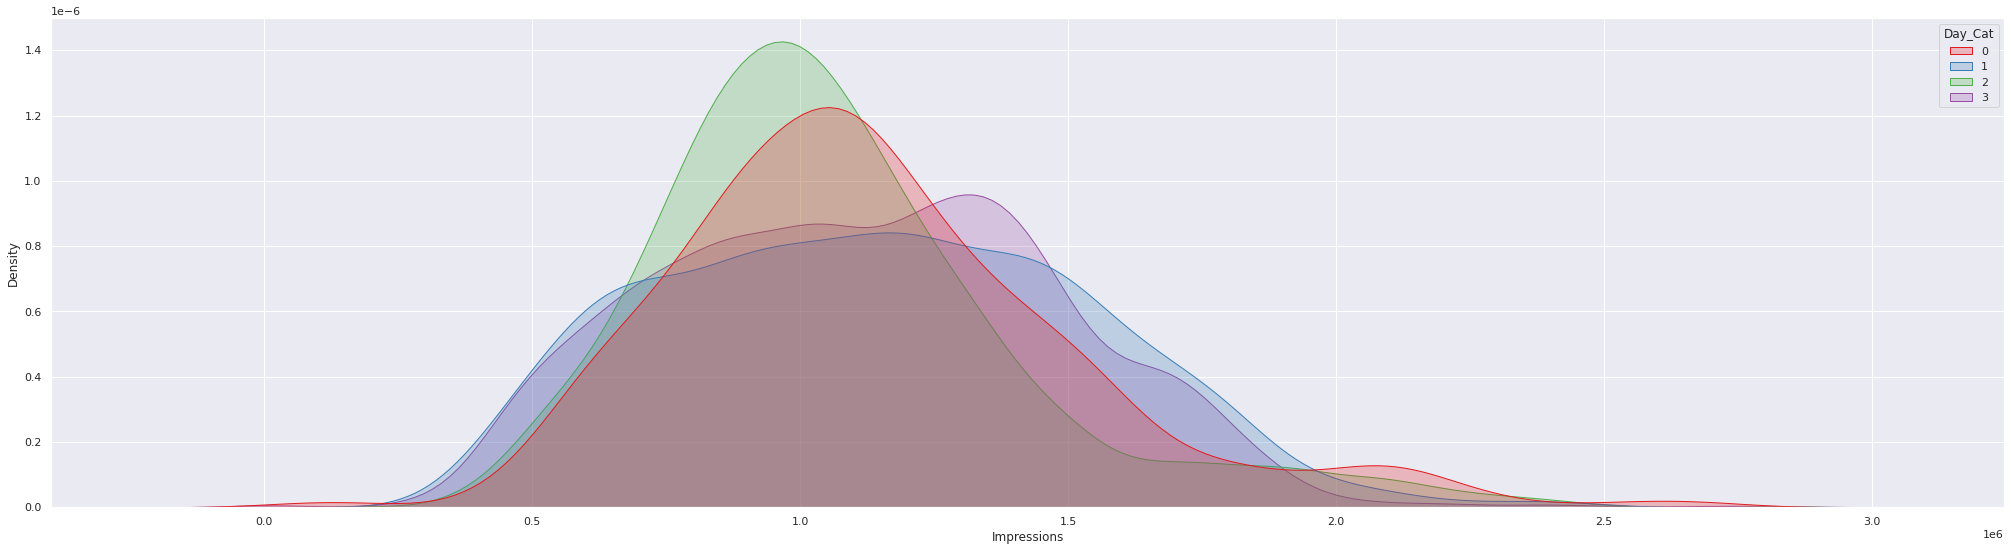

In [6]:
_ = sns.kdeplot(
    data=train, x='Impressions', hue="Day_Cat",
    palette=sns.color_palette("Set1")[:4], 
    fill=True, common_norm=False
)

### Изучим время между записями в каждом из DC

In [7]:
def series_timedelta(series):
    res = series.iloc[1:].to_numpy() - series.iloc[:-1].to_numpy()
    res = res.astype('timedelta64[m]')
    return [np.NaN, *res]

def draw_bar_labels(rects, ax):
    total_len = sum(map(lambda x: x.get_height(), rects))
    for rect in rects:
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2., 1.05 * height,
            f'{int(height)} - {round(height / total_len, 4) * 100}%',
            ha='center', va='bottom'
        )

In [8]:
dc1_train = train[train['DC1'] == 1].sort_values('Date')
dc2_train = train[train['DC2'] == 1].sort_values('Date')

dc1_train['tdelta'] = series_timedelta(dc1_train['Date'])
dc2_train['tdelta'] = series_timedelta(dc2_train['Date'])

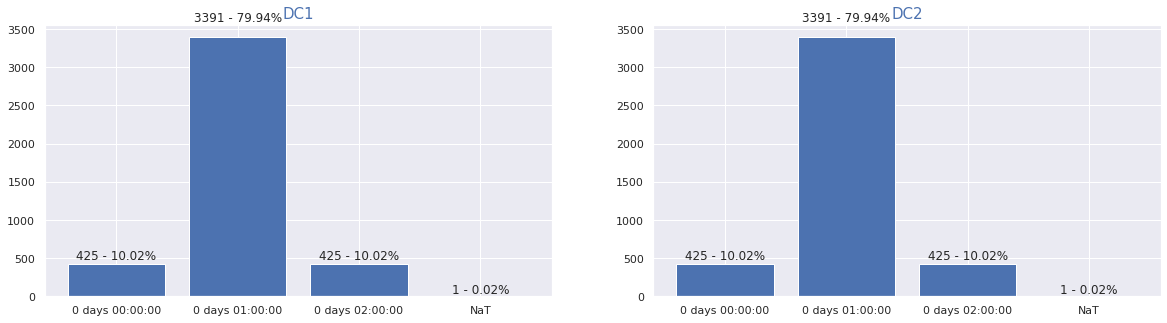

In [9]:
_, ax = plt.subplots(1, 2, figsize=(20, 5))

dc1_un, dc1_count = np.unique(dc1_train['tdelta'].map(str), return_counts=True)
dc2_un, dc2_count = np.unique(dc2_train['tdelta'].map(str), return_counts=True)

ax[0].set_title('DC1', fontsize=15, c='b')
rects = ax[0].bar(dc1_un, dc1_count)
draw_bar_labels(rects, ax[0])

ax[1].set_title('DC2', fontsize=15, c='b')
rects2 = ax[1].bar(dc2_un, dc2_count)
draw_bar_labels(rects2, ax[1])

Заметим, что достаточно большой процент записей с одинаковым временем в каждом из DC. Давайте рассмотрим эти записи.

In [10]:
tdelta_vals = dc1_train['tdelta'].unique()
dc1_train['tdelta_next'] = [*dc1_train['tdelta'].iloc[1:], 0]
dc2_train['tdelta_next'] = [*dc2_train['tdelta'].iloc[1:], 0]


dc1_eq_pairs = dc1_train[
    (dc1_train['tdelta'] == tdelta_vals[-1]) | 
    (dc1_train['tdelta_next'] == tdelta_vals[-1])
]

dc2_eq_pairs = dc2_train[
    (dc2_train['tdelta'] == tdelta_vals[-1]) | 
    (dc2_train['tdelta_next'] == tdelta_vals[-1])
]

In [11]:
dc1_eq_pairs.sort_values(['Date', 'Bids']).head(16)

,Bids,Impressions,Spent,Date,Day,Hour,Week,Month,WeekDay,WorkDay,Is_Daylight,Day_Cat,DC1,DC2,tdelta,tdelta_next
472,3051694.0,731126.0,1092303.0,2020-01-11 02:00:00,11,2,1,1,5,False,False,0,1.0,0.0,0 days 00:00:00,0 days 01:00:00
471,3463302.0,824982.0,358272.0,2020-01-11 02:00:00,11,2,1,1,5,False,False,0,1.0,0.0,0 days 01:00:00,0 days 00:00:00
482,2574526.0,441600.0,521394.0,2020-01-11 07:00:00,11,7,1,1,5,False,False,0,1.0,0.0,0 days 02:00:00,0 days 00:00:00
481,4876006.0,1278855.0,516877.0,2020-01-11 07:00:00,11,7,1,1,5,False,False,0,1.0,0.0,0 days 00:00:00,0 days 01:00:00
496,3648582.0,612428.0,702542.0,2020-01-11 14:00:00,11,14,1,1,5,False,True,1,1.0,0.0,0 days 00:00:00,0 days 01:00:00
495,5284566.0,1062823.0,525199.0,2020-01-11 14:00:00,11,14,1,1,5,False,True,1,1.0,0.0,0 days 01:00:00,0 days 00:00:00
505,2662084.0,586620.0,360673.0,2020-01-11 19:00:00,11,19,1,1,5,False,True,1,1.0,0.0,0 days 02:00:00,0 days 00:00:00
506,3244062.0,598568.0,826182.0,2020-01-11 19:00:00,11,19,1,1,5,False,True,1,1.0,0.0,0 days 00:00:00,0 days 01:00:00
522,2795436.0,628052.0,822097.0,2020-01-12 03:00:00,12,3,1,1,6,False,False,0,1.0,0.0,0 days 00:00:00,0 days 01:00:00
521,2843679.0,726833.0,232512.0,2020-01-12 03:00:00,12,3,1,1,6,False,False,0,1.0,0.0,0 days 01:00:00,0 days 00:00:00


### Попробуем отфильтровать повторы строк. Отобразим точки в пространстве.

In [12]:
train_cp = train.fillna(-1)
train_cp['color'] = 0

for idx in dc1_eq_pairs.iloc[::2].index:
    train_cp['color'][idx] = 1
    
for idx in dc2_eq_pairs.iloc[::2].index:
    train_cp['color'][idx] = 1
    
for idx in dc1_eq_pairs.iloc[1::2].index:
    train_cp['color'][idx] = 2
    
for idx in dc2_eq_pairs.iloc[1::2].index:
    train_cp['color'][idx] = 2

In [13]:
train_red = TSNE(
    random_state=42, perplexity=25
).fit_transform(train_cp[['Bids', 'Impressions', 'Spent']].fillna(-1))

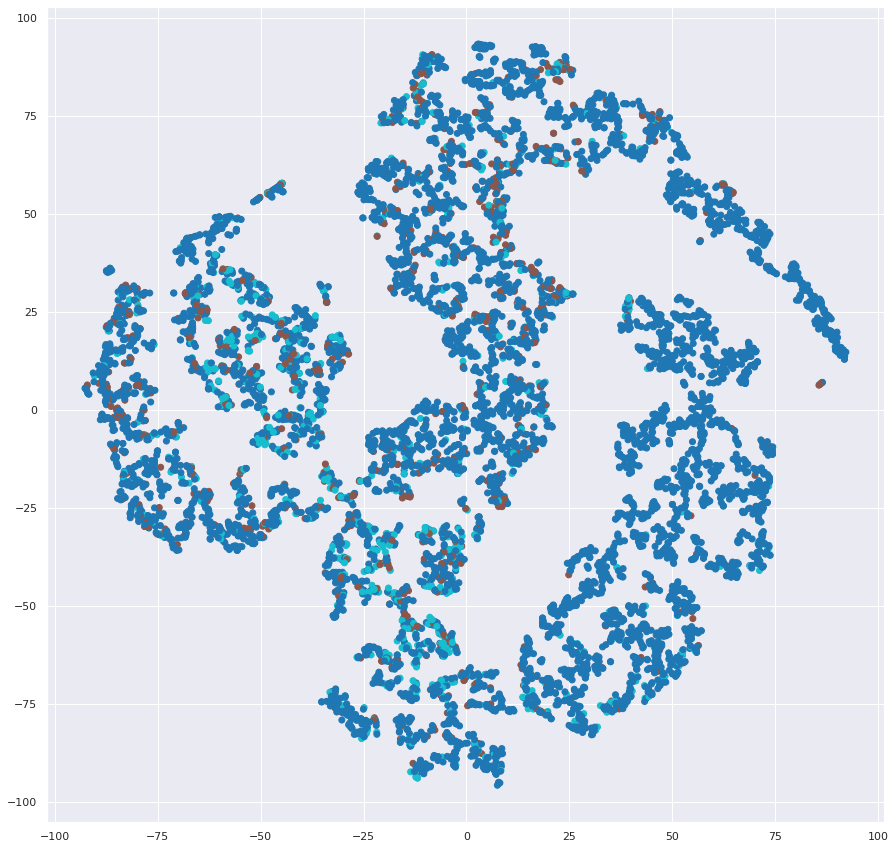

In [14]:
plt.figure(figsize=(15, 15))
plt.scatter(train_red[:, 0], train_red[:, 1], c=train_cp['color'], cmap='tab10')

Видно, что среди дублирующиеся строк сложно выделить валидные.

### Изучим распределение показатей во времени

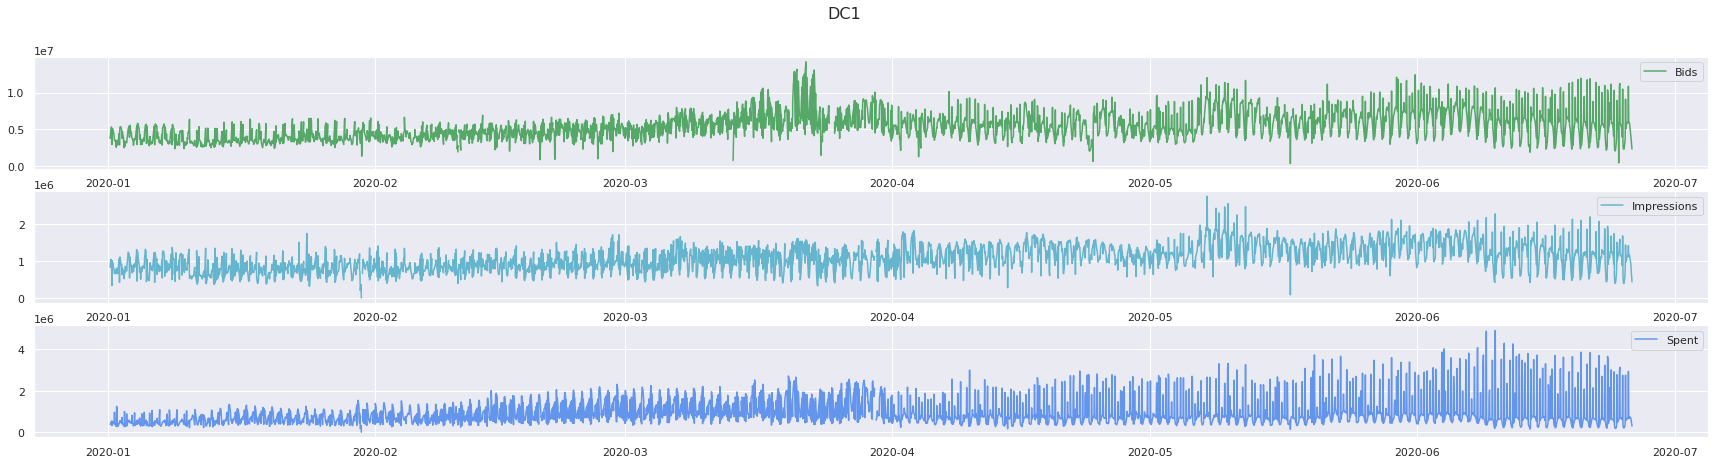

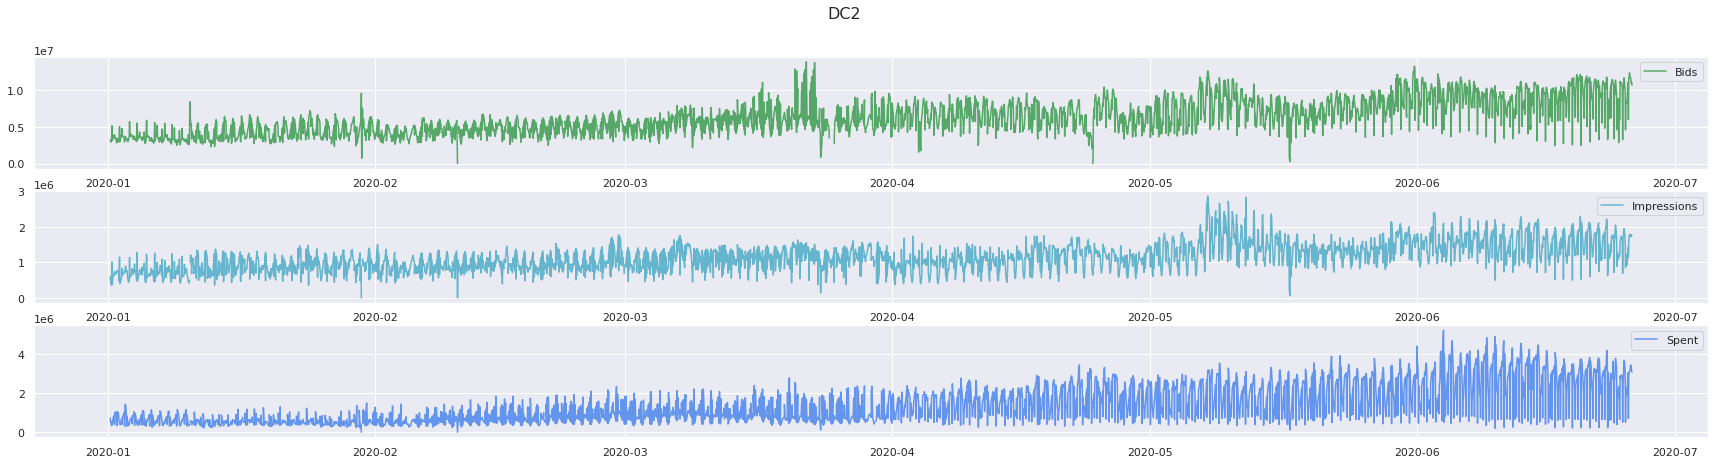

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(30, 7))
fig2, ax2 = plt.subplots(3, 1, figsize=(30, 7))

fig.suptitle('DC1', fontsize=16)
fig2.suptitle('DC2', fontsize=16)

dc1_train = train[train['DC1'] == 1].sort_values('Date')
dc2_train = train[train['DC2'] == 1].sort_values('Date')
    
ax[0].plot(dc1_train['Date'], dc1_train['Bids'], color='g', label='Bids')
ax[1].plot(dc1_train['Date'], dc1_train['Impressions'], color='c', label='Impressions')
ax[2].plot(dc1_train['Date'], dc1_train['Spent'], color='cornflowerblue', label='Spent')

ax2[0].plot(dc2_train['Date'], dc2_train['Bids'], color='g', label='Bids')
ax2[1].plot(dc2_train['Date'], dc2_train['Impressions'], color='c', label='Impressions')
ax2[2].plot(dc2_train['Date'], dc2_train['Spent'], color='cornflowerblue', label='Spent')

for axis in zip(ax, ax2):
    axis[0].legend()
    axis[1].legend()

### Добавим scaler и снизим размерность данных для удобства

In [16]:
tsne_train = train.drop('Date', axis=1)
tsne_train.fillna(-1, inplace=True)

sclr = StandardScaler()
tsne_train = sclr.fit_transform(tsne_train)

dr_model = PCA(n_components=10, random_state=42)
X_embedded = dr_model.fit_transform(
    tsne_train
)

Проверим долю объясненной дисперсии

In [17]:
dr_model.explained_variance_ratio_.sum()

1.0000000000000002

In [18]:
emb_sclr = StandardScaler()
X_embedded = emb_sclr.fit_transform(X_embedded)

train_emb_data = pd.DataFrame(X_embedded)

### Методом локтя определим количество кластеров

  0%|          | 0/20 [00:00<?, ?it/s]

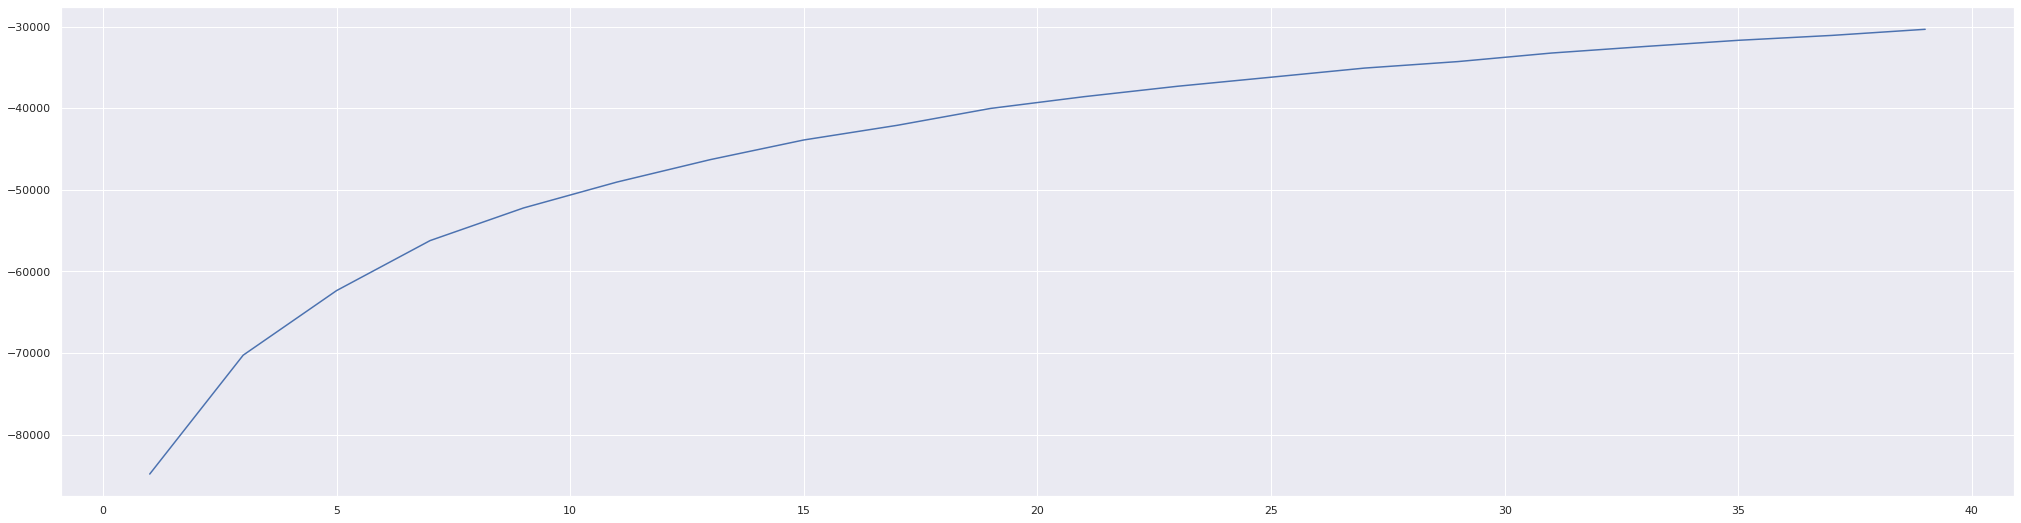

In [19]:
n_cluster = range(1, 40, 2)

kmeans = [KMeans(n_clusters=i).fit(train_emb_data) for i in tqdm(n_cluster)]
scores = [kmeans[i].score(train_emb_data) for i in range(len(kmeans))]

fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

Возьмем n=12 штук

In [20]:
clst_model = kmeans[12]
train_emb_data['class'] = clst_model.predict(train_emb_data)
train_emb_data['class'] = train_emb_data['class'].astype(int)

In [21]:
train_emb_data['class'].value_counts()

2     521
9     445
16    432
7     426
1     405
6     402
11    401
19    398
3     393
15    385
17    382
8     372
21    366
0     349
13    347
10    346
4     306
20    299
5     280
22    263
14    251
24    244
12    207
23    186
18     78
Name: class, dtype: int64

In [22]:
def get_cluster_distance(data, model, n_dims=2):
    distances = []
    centers = model.cluster_centers_
    for i in range(len(data)):
        row = data.iloc[i]
        cl_id = int(row['class'])
        row_data = row[:n_dims].to_numpy()
        dists = np.linalg.norm(row_data - centers, axis=1)

        # ignore current cluster
        dists[cl_id] = np.inf
        distances.append(dists.min())
    
    return distances

In [23]:
train_emb_data['dists'] = get_cluster_distance(train_emb_data, clst_model, train_emb_data.shape[1]-1)
train_emb_data.sort_values('dists', inplace=True)

<AxesSubplot:xlabel='dists'>

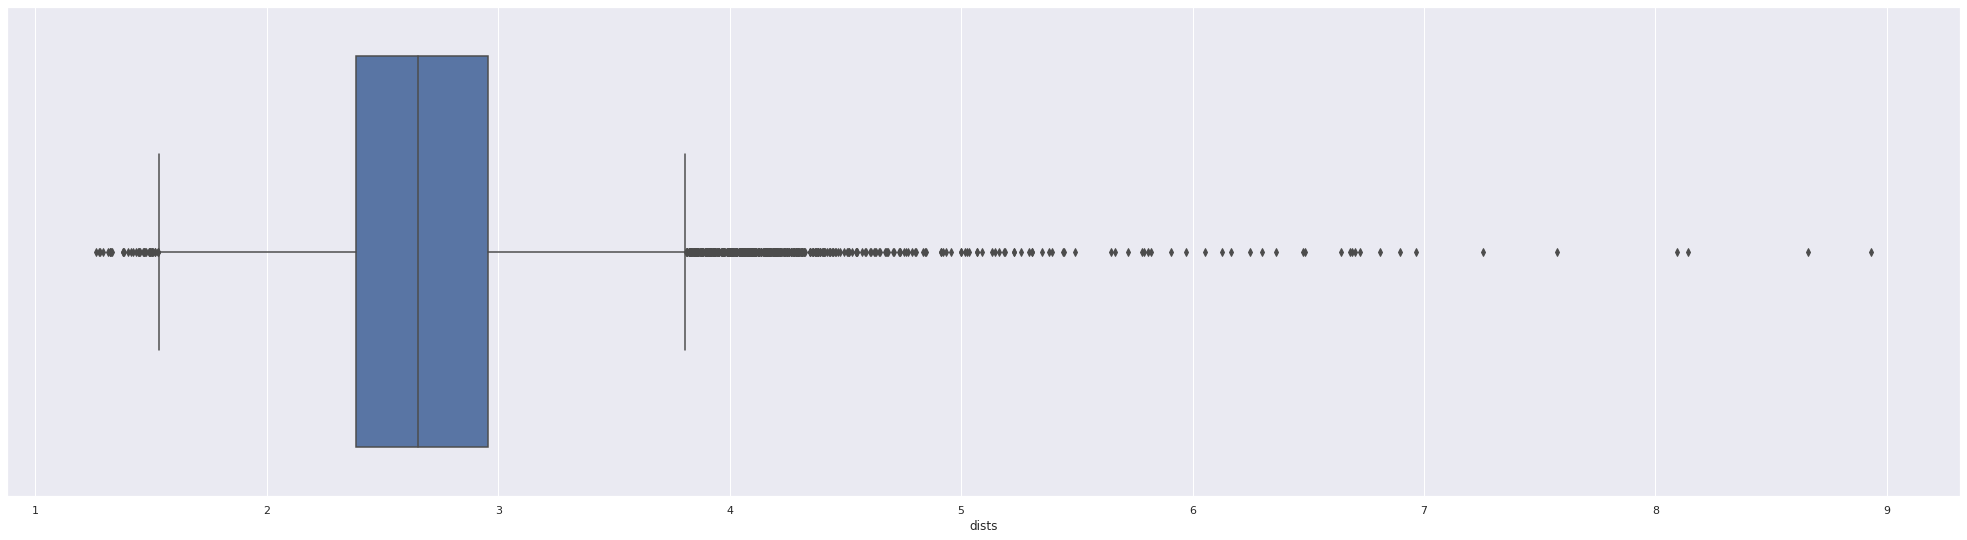

In [24]:
sns.boxplot(train_emb_data['dists'])

In [25]:
outliers_fraction = 0.023
train_emb_data['is_outlier'] = 0
train_emb_data['is_outlier'].iloc[-int(len(train_emb_data) * outliers_fraction):] = 1

In [26]:
frst = IsolationForest(random_state=42, contamination=outliers_fraction)
frst_train = train.drop('Date', axis=1)
frst_train.fillna(-1, inplace=True)

train['is_outlier_frst'] = frst.fit_predict(frst_train)

In [27]:
train['is_outlier_frst'].value_counts()

 1    8288
-1     196
Name: is_outlier_frst, dtype: int64

In [28]:
train['is_outlier_frst'] = train_emb_data['is_outlier']

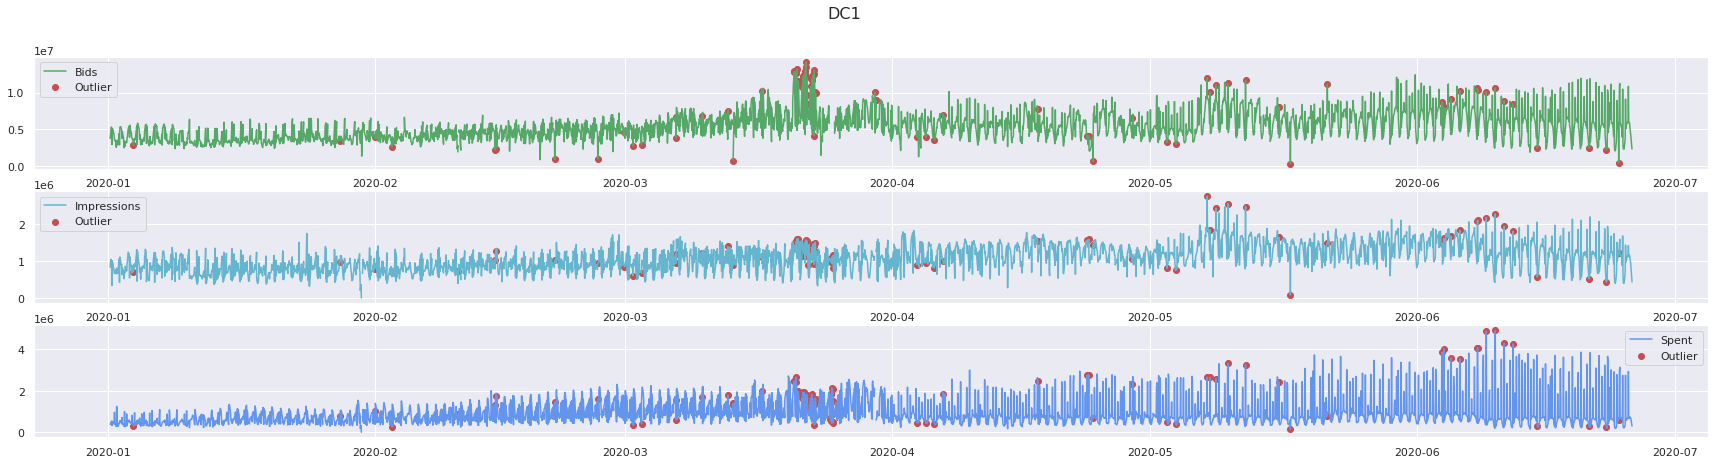

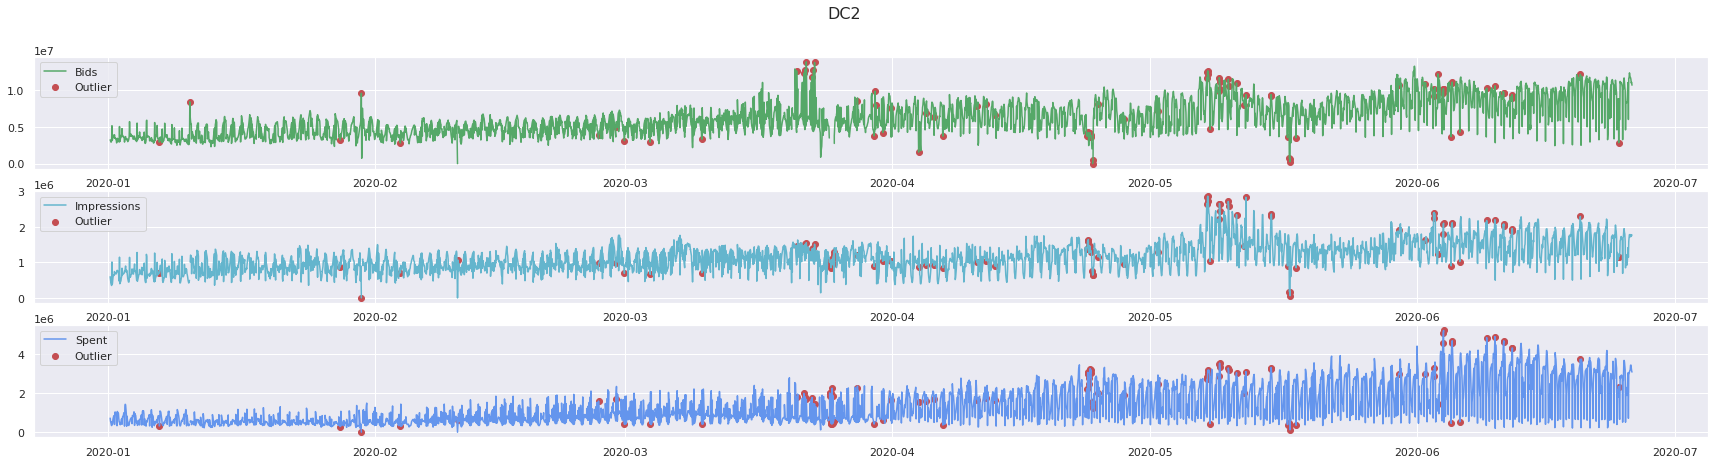

In [29]:
fig, ax = plt.subplots(3, 1, figsize=(30, 7))
fig2, ax2 = plt.subplots(3, 1, figsize=(30, 7))

fig.suptitle('DC1', fontsize=16)
fig2.suptitle('DC2', fontsize=16)

_train = train 
outlier_flag = 1

dc1_train = _train[_train['DC1'] == 1].sort_values('Date')
dc2_train = _train[_train['DC2'] == 1].sort_values('Date')

dc1_train_out = dc1_train[dc1_train['is_outlier_frst'] == outlier_flag]
dc2_train_out = dc2_train[dc2_train['is_outlier_frst'] == outlier_flag]


ax[0].plot(dc1_train['Date'], dc1_train['Bids'], color='g', label='Bids')
ax[1].plot(dc1_train['Date'], dc1_train['Impressions'], color='c', label='Impressions')
ax[2].plot(dc1_train['Date'], dc1_train['Spent'], color='cornflowerblue', label='Spent')

ax[0].scatter(dc1_train_out['Date'], dc1_train_out['Bids'], color='r', label='Outlier')
ax[1].scatter(dc1_train_out['Date'], dc1_train_out['Impressions'], color='r', label='Outlier')
ax[2].scatter(dc1_train_out['Date'], dc1_train_out['Spent'], color='r', label='Outlier')


ax2[0].plot(dc2_train['Date'], dc2_train['Bids'], color='g', label='Bids')
ax2[1].plot(dc2_train['Date'], dc2_train['Impressions'], color='c', label='Impressions')
ax2[2].plot(dc2_train['Date'], dc2_train['Spent'], color='cornflowerblue', label='Spent')


ax2[0].scatter(dc2_train_out['Date'], dc2_train_out['Bids'], color='r', label='Outlier')
ax2[1].scatter(dc2_train_out['Date'], dc2_train_out['Impressions'], color='r', label='Outlier')
ax2[2].scatter(dc2_train_out['Date'], dc2_train_out['Spent'], color='r', label='Outlier')


for axis in zip(ax, ax2):
    axis[0].legend()
    axis[1].legend()

In [30]:
outliers = train[train['is_outlier_frst'] == 1].drop_duplicates('Date')

### Найденные аутлаеры:

In [31]:
outliers

,Bids,Impressions,Spent,Date,Day,Hour,Week,Month,WeekDay,WorkDay,Is_Daylight,Day_Cat,DC1,DC2,is_outlier_frst
130,2827098.0,711271.0,299776.0,2020-01-03 23:00:00,3,23,1,1,4,True,False,2,1.0,0.0,1
274,2924768.0,706190.0,317771.0,2020-01-06 23:00:00,6,23,1,1,0,True,False,2,0.0,1.0,1
1281,3221150.0,876091.0,291531.0,2020-01-27 23:00:00,27,23,1,1,0,True,False,2,0.0,1.0,1
1399,9570377.0,496.0,629.0,2020-01-30 10:00:00,30,10,1,1,3,True,True,3,0.0,1.0,1
1470,3995597.0,781132.0,1008970.0,2020-01-31 23:00:00,31,23,1,1,4,True,False,2,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7954,2452029.0,565789.0,284837.0,2020-06-14 23:00:00,14,23,6,6,6,False,False,0,1.0,0.0,1
8195,12137510.0,2291733.0,3733500.0,2020-06-19 23:00:00,19,23,6,6,4,True,False,2,0.0,1.0,1
8242,2452985.0,509634.0,285880.0,2020-06-20 23:00:00,20,23,6,6,5,False,False,0,1.0,0.0,1
8338,2196802.0,439920.0,254587.0,2020-06-22 23:00:00,22,23,6,6,0,True,False,2,1.0,0.0,1
